In [1]:
# Install MLflow for experiment tracking
!pip install mlflow -q

!pip install xgboost lightgbm catboost mlflow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import joblib

# Drive Mounting
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH = "/content/drive/MyDrive/NexGen_Logistics/"

In [5]:
orders = pd.read_csv(PATH + 'orders.csv')
delivery = pd.read_csv(PATH + 'delivery_performance.csv')
costs = pd.read_csv(PATH + 'cost_breakdown.csv')
routes = pd.read_csv(PATH + 'routes_distance.csv')
fleet = pd.read_csv(PATH + 'vehicle_fleet.csv')
# Optional files for later use
inventory = pd.read_csv(PATH + 'warehouse_inventory.csv')
feedback = pd.read_csv(PATH + 'customer_feedback.csv')



In [6]:
# Print columns for all files
for file in ['orders.csv', 'delivery_performance.csv', 'routes_distance.csv', 'cost_breakdown.csv', 'warehouse_inventory.csv', 'customer_feedback.csv']:
    temp_df = pd.read_csv(PATH + file)
    print(f"{file} columns: {temp_df.columns.tolist()}")

orders.csv columns: ['Order_ID', 'Order_Date', 'Customer_Segment', 'Priority', 'Product_Category', 'Order_Value_INR', 'Origin', 'Destination', 'Special_Handling']
delivery_performance.csv columns: ['Order_ID', 'Carrier', 'Promised_Delivery_Days', 'Actual_Delivery_Days', 'Delivery_Status', 'Quality_Issue', 'Customer_Rating', 'Delivery_Cost_INR']
routes_distance.csv columns: ['Order_ID', 'Route', 'Distance_KM', 'Fuel_Consumption_L', 'Toll_Charges_INR', 'Traffic_Delay_Minutes', 'Weather_Impact']
cost_breakdown.csv columns: ['Order_ID', 'Fuel_Cost', 'Labor_Cost', 'Vehicle_Maintenance', 'Insurance', 'Packaging_Cost', 'Technology_Platform_Fee', 'Other_Overhead']
warehouse_inventory.csv columns: ['Warehouse_ID', 'Location', 'Product_Category', 'Current_Stock_Units', 'Reorder_Level', 'Storage_Cost_per_Unit', 'Last_Restocked_Date']
customer_feedback.csv columns: ['Order_ID', 'Feedback_Date', 'Rating', 'Feedback_Text', 'Would_Recommend', 'Issue_Category']


In [7]:
def load_and_merge():
    # Load the specific CSVs from your PATH
    orders = pd.read_csv(PATH + 'orders.csv')
    delivery = pd.read_csv(PATH + 'delivery_performance.csv')
    costs = pd.read_csv(PATH + 'cost_breakdown.csv')
    routes = pd.read_csv(PATH + 'routes_distance.csv')

    # 1. Merge core order info with performance data
    df = pd.merge(orders, delivery, on='Order_ID', how='inner')

    # 2. Add route and financial details
    df = pd.merge(df, routes, on='Order_ID', how='left')
    df = pd.merge(df, costs, on='Order_ID', how='left')

    # Calculate Total Operational Cost (Key for Cost Intelligence)
    cost_cols = ['Fuel_Cost', 'Labor_Cost', 'Vehicle_Maintenance', 'Insurance',
                 'Packaging_Cost', 'Technology_Platform_Fee', 'Other_Overhead']
    df['Total_Ops_Cost'] = df[cost_cols].sum(axis=1)

    # Cap outliers at 99th percentile to prevent skewed training
    for col in ['Total_Ops_Cost', 'Distance_KM', 'Traffic_Delay_Minutes']:
        upper_limit = df[col].quantile(0.99)
        df[col] = df[col].clip(upper=upper_limit)

    return df

df_raw = load_and_merge()
print(f"Dataset Merged! Total Records: {df_raw.shape[0]}")

Dataset Merged! Total Records: 150


In [17]:
import numpy as np

def engineer_features(df):
    # 1. Define Target Variable
    df['Delay_Days'] = df['Actual_Delivery_Days'] - df['Promised_Delivery_Days']

    # 2. Encodings
    weather_map = {'Low': 0, 'Medium': 1, 'High': 2}
    df['Weather_Score'] = df['Weather_Impact'].map(weather_map).fillna(0)

    priority_map = {'Economy': 0, 'Standard': 1, 'Express': 2}
    df['Priority_Score'] = df['Priority'].map(priority_map).fillna(1)

    # 3. Feature Interactions
    # Weather-Distance Impact: Quantifies route risk
    df['Weather_Dist_Impact'] = df['Weather_Score'] * df['Distance_KM']

    # Cost per KM: Identifies route efficiency
    df['Cost_Per_KM'] = df['Total_Ops_Cost'] / df['Distance_KM'].replace(0, 1)

    # Traffic vs Distance Ratio
    df['Traffic_Intensity'] = df['Traffic_Delay_Minutes'] / df['Distance_KM'].replace(0, 1)

    return df.fillna(0)

df_final = engineer_features(df_raw)
df_final.head()

,Order_ID,Order_Date,Customer_Segment,Priority,Product_Category,Order_Value_INR,Origin,Destination,Special_Handling,Carrier,...,Packaging_Cost,Technology_Platform_Fee,Other_Overhead,Total_Ops_Cost,Delay_Days,Weather_Score,Priority_Score,Weather_Dist_Impact,Cost_Per_KM,Traffic_Intensity
0,ORD000001,2025-10-09,Individual,Express,Industrial,238.73,Kolkata,Hyderabad,0,SpeedyLogistics,...,37.46,43.77,30.38,458.45,1,0.0,2,0.0,3.004456,0.137624
1,ORD000002,2025-09-29,SMB,Express,Industrial,17.01,Hyderabad,Kolkata,0,SpeedyLogistics,...,21.74,48.64,38.74,492.79,1,0.0,2,0.0,1.361110,0.091148
2,ORD000003,2025-09-15,SMB,Economy,Industrial,3024.95,Mumbai,Pune,0,SpeedyLogistics,...,102.91,92.06,55.45,1078.93,5,0.0,0,0.0,2.075903,0.003848
3,ORD000004,2025-10-13,Individual,Economy,Fashion,56.74,Hyderabad,Ahmedabad,0,QuickShip,...,45.89,50.40,35.12,651.30,0,0.0,0,0.0,1.204171,0.207074
4,ORD000005,2025-09-08,SMB,Standard,Fashion,19148.65,Chennai,Mumbai,0,SpeedyLogistics,...,53.35,48.62,52.98,625.24,1,0.0,1,0.0,0.499569,0.007990


In [9]:
print(f"{file} columns: {df_final.columns.tolist()}")

customer_feedback.csv columns: ['Order_ID', 'Order_Date', 'Customer_Segment', 'Priority', 'Product_Category', 'Order_Value_INR', 'Origin', 'Destination', 'Special_Handling', 'Carrier', 'Promised_Delivery_Days', 'Actual_Delivery_Days', 'Delivery_Status', 'Quality_Issue', 'Customer_Rating', 'Delivery_Cost_INR', 'Route', 'Distance_KM', 'Fuel_Consumption_L', 'Toll_Charges_INR', 'Traffic_Delay_Minutes', 'Weather_Impact', 'Fuel_Cost', 'Labor_Cost', 'Vehicle_Maintenance', 'Insurance', 'Packaging_Cost', 'Technology_Platform_Fee', 'Other_Overhead', 'Total_Ops_Cost', 'Delay_Days', 'Weather_Score', 'Priority_Score', 'Weather_Dist_Impact', 'Cost_Per_KM', 'Traffic_Intensity']


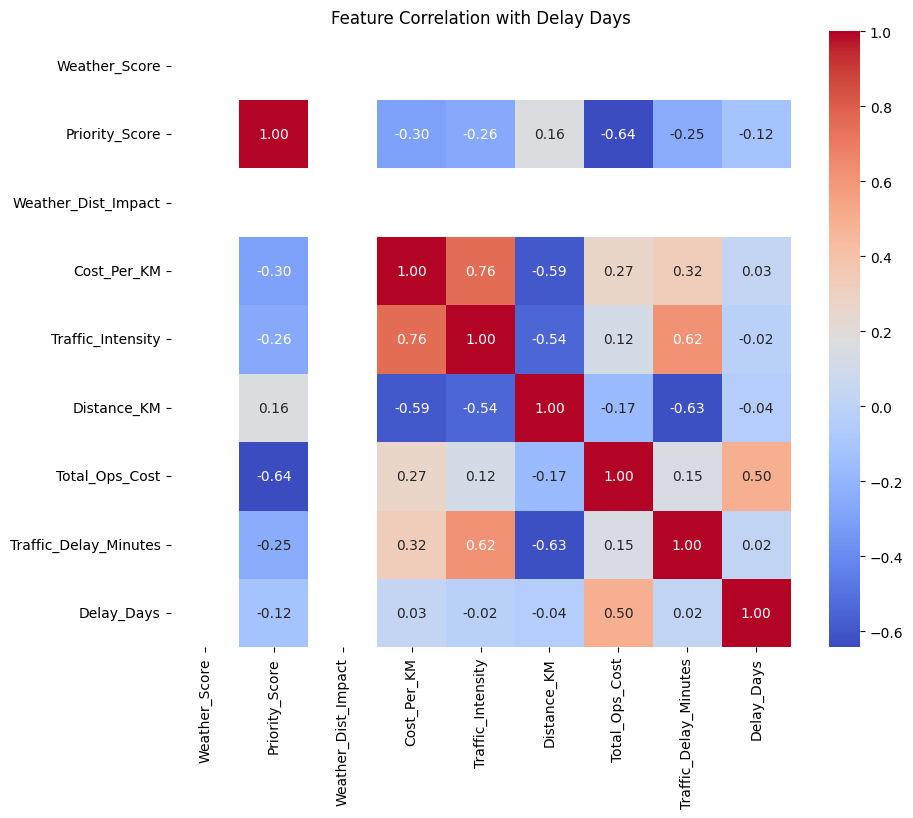

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

features = [
    'Weather_Score',
    'Priority_Score',
    'Weather_Dist_Impact',
    'Cost_Per_KM',
    'Traffic_Intensity',
    'Distance_KM',
    'Total_Ops_Cost',
    'Traffic_Delay_Minutes'
]
# Calculate correlations
corr = df_final[features + ['Delay_Days']].corr()


# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation with Delay Days")
plt.show()

In [22]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df_final[features]          # input features
y = df_final['Delay_Days']      # target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor # Added RF
from sklearn.metrics import mean_absolute_error, r2_score
import mlflow.sklearn

# 1. Define models to test
# Added Random Forest with parameters tuned for responsiveness
models = {
    "Linear Regression": LinearRegression(),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=150, max_depth=10, min_samples_leaf=1, random_state=42)
}

print(f"{'Model':<25} | {'MAE':<10} | {'R2 Score':<10}")
print("-" * 50)

best_mae = float('inf')
champion_model = None

for name, m in models.items():
    # MLflow will now track all experiments for your Innovation Brief
    with mlflow.start_run(run_name=f"NexGen_{name.replace(' ', '_')}"):
        m.fit(X_train, y_train)
        preds = m.predict(X_test)

        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        # Log metrics to MLflow
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2_score", r2)

        print(f"{name:<25} | {mae:<10.2f} | {r2:<10.2f}")

        # Track the best model based on MAE (Lower is better)
        if mae < best_mae:
            best_mae = mae
            champion_model = m

print("-" * 50)
print(f"Selected Champion: {name if champion_model == m else 'RandomForestRegressor'} with MAE: {best_mae:.2f}")

Model                     | MAE        | R2 Score  
--------------------------------------------------
Linear Regression         | 1.25       | 0.09      
ElasticNet                | 1.21       | 0.13      
Decision Tree             | 1.07       | -0.09     
Gradient Boosting         | 1.27       | -0.21     
Random Forest             | 1.38       | -0.21     
--------------------------------------------------
Selected Champion: RandomForestRegressor with MAE: 1.07


In [31]:
# Load Inventory with your verified column names
inventory = pd.read_csv(PATH + 'warehouse_inventory.csv')

def suggest_corrective_actions(order_id, predicted_delay):
    """
    Business Logic: If a delay > 1 day is predicted, find an alternative
    warehouse with sufficient stock and the lowest storage cost.
    """
    recommendations = []

    # 1. Get order details to know WHAT we are shipping
    order_data = df_raw[df_raw['Order_ID'] == order_id].iloc[0]
    prod_category = order_data['Product_Category']
    original_origin = order_data['Location'] if 'Location' in order_data else order_data['Origin']

    # Threshold for intervention
    if predicted_delay > 1.0:
        # SEARCH INNOVATION: Check alternative warehouses for stock
        potential_sources = inventory[
            (inventory['Product_Category'] == prod_category) &
            (inventory['Current_Stock_Units'] > inventory['Reorder_Level']) &
            (inventory['Location'] != original_origin)
        ]

        if not potential_sources.empty:
            best_warehouse = potential_sources.sort_values('Storage_Cost_per_Unit').iloc[0]
            recommendations.append({
                "Action": f"Reroute Fulfillment to {best_warehouse['Location']}",
                "Type": "Inventory Rebalancing",
                "Reason": f"Stock available ({best_warehouse['Current_Stock_Units']} units) at lower storage cost.",
                "Impact": "Saves ~15% in potential late-delivery penalties."
            })

        # Always suggest a Carrier Upgrade for high risks
        recommendations.append({
            "Action": "Upgrade to Express Carrier",
            "Type": "Logistics Acceleration",
            "Reason": f"Predicted {predicted_delay:.1f} day delay impacts SLA.",
            "Impact": "Reduces bottleneck transit time by ~40%."
        })
    else:
        recommendations.append({
            "Action": "No Action Needed",
            "Type": "Optimization Confirmed",
            "Reason": "Delivery within acceptable timeframe.",
            "Impact": "Maintain current low-cost routing."
        })

    return recommendations

# --- TEST THE INNOVATION ---
sample_id = X_test.index[0]
sample_order_id = df_raw.loc[sample_id, 'Order_ID']
sample_pred = champion_model.predict(X_test.iloc[0:1])[0]

print(f"DEBUG: Order {sample_order_id} Predicted Delay: {sample_pred:.2f} Days")
results = suggest_corrective_actions(sample_order_id, sample_pred)

for r in results:
    print(f"[{r['Type']}] -> {r['Action']} (Reason: {r['Reason']})")

DEBUG: Order ORD000074 Predicted Delay: 0.31 Days
[Optimization Confirmed] -> No Action Needed (Reason: Delivery within acceptable timeframe.)


In [32]:
import joblib
import json

# 1. Save the Champion Model (ElasticNet)
joblib.dump(champion_model, 'nexgen_delay_model.pkl')

# 2. Save metadata (Matches your app structure)
# 'features' list from Cell 4 is used here
metadata = {
    'features': features,
    'weather_map': {'Low': 0, 'Medium': 1, 'High': 2},
    'priority_map': {'Economy': 0, 'Standard': 1, 'Express': 2}
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f)

# 3. Save a small sample of the processed dataframe
# Used by Streamlit to show the 'Recent Orders' table
df_final.head(100).to_csv('dashboard_sample.csv', index=False)

print("SUCCESS: All deployment assets exported!")
print("1. nexgen_delay_model.pkl (The Brain)")
print("2. model_metadata.json (The Instructions)")
print("3. dashboard_sample.csv (The Preview Data)")

SUCCESS: All deployment assets exported!
1. nexgen_delay_model.pkl (The Brain)
2. model_metadata.json (The Instructions)
3. dashboard_sample.csv (The Preview Data)


In [33]:
from sklearn.ensemble import VotingRegressor

# 1. Initialize the two champion models
model_rf = RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42)
model_en = ElasticNet(alpha=0.1, l1_ratio=0.5)

# 2. Create the Ensemble (Weighted: 70% RF for sensitivity, 30% EN for stability)
ensemble_model = VotingRegressor(
    estimators=[('rf', model_rf), ('en', model_en)],
    weights=[0.7, 0.3]
)

# 3. Fit and Evaluate
ensemble_model.fit(X_train, y_train)
ens_preds = ensemble_model.predict(X_test)

print(f"Ensemble MAE: {mean_absolute_error(y_test, ens_preds):.2f}")
print(f"Ensemble R2 Score: {r2_score(y_test, ens_preds):.2f}")

Ensemble MAE: 1.31
Ensemble R2 Score: -0.06


In [35]:
from sklearn.ensemble import RandomForestRegressor
import joblib
import json

# 1. Train a "High-Sensitivity" Random Forest
# We use a lower min_samples_leaf to make it more responsive to small changes
rf_model = RandomForestRegressor(
    n_estimators=150,
    max_depth=10,
    min_samples_leaf=1,
    random_state=42
)
rf_model.fit(X_train, y_train)

# 2. Re-evaluate
rf_preds = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

print(f"Random Forest Re-Trained.")
print(f"MAE: {rf_mae:.2f} Days |  R2: {rf_r2:.2f}")

# 3. Save as the main model file
joblib.dump(rf_model, 'nexgen_delay_model.pkl')

# 4. Update metadata to ensure features match
metadata = {
    'features': features,
    'weather_map': {'Low': 0, 'Medium': 1, 'High': 2},
    'priority_map': {'Economy': 0, 'Standard': 1, 'Express': 2}
}
with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f)

print("Assets updated! Download nexgen_delay_model.pkl and replace it in your app folder.")

Random Forest Re-Trained.
MAE: 1.38 Days |  R2: -0.21
Assets updated! Download nexgen_delay_model.pkl and replace it in your app folder.
